In [1]:
using ElectronPropagation
using PyPlot
using FFTW
smoothe(A, x, y, σ) = ifftshift(ifft(fft(A) .* fft(@. exp(-(x^2+y'^2)/σ^2))))
;

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
dpi = 200
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
norm = PyPlot.matplotlib.colors.Normalize(vmin=0, vmax=1)
;

In [3]:
U = 30e3

L = 50e-6
z = 0.5
w = 15e-6  # electron beam radius

λ = deBroglieWavelength(U)

# sampling
Δx = λ * z / L / 4

x = Vector{Float64}(range(-L/2, L/2-Δx, step=Δx))
y = copy(x)
;

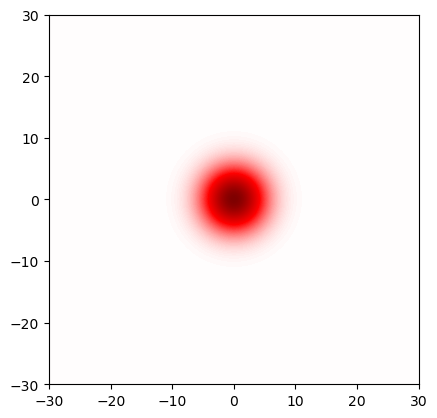

In [4]:
λ_l = 1035e-9
Δimg = 0.01e-6

wgauss = 5e-6

ximg = Vector{Float64}(range(-30e-6, 30e-6, step=Δimg))
yimg = ximg

I = @. exp(-(ximg^2+yimg'^2)/wgauss^2)
extent_l = [ximg[1], ximg[end], yimg[1], yimg[end]] .* 1e6
pygui(false)
imshow(I, extent=extent_l, cmap=red)
;

In [5]:
n, m = size(I)
I_cross = I[3001, :]
offset = 0.1
func(x) = x > 0.5
bounds = findall(func, I_cross)
display(ximg[bounds[end]]-ximg[bounds[1]])

8.319999999999998e-6

In [6]:
c = 299792458           # the speed of light
ħ = 1.054571817e-34     # the reduced planck constant
m_e = 9.1093837015e-31  # the electron mass
q = 1.602176634e-19     # electron charge
ε_0 = 8.8541878128e-12  # vacuum permitivity

v = c * sqrt(1 - 1 / (1 + q*U/m_e/c^2)^2)
α = 1 / (4 * π * ε_0) * q^2 / (ħ * c)
β = v / c
γ = 1 / sqrt(1 - β^2)
Ee = γ*m_e*c^2
;

-2.283502477459125e-8

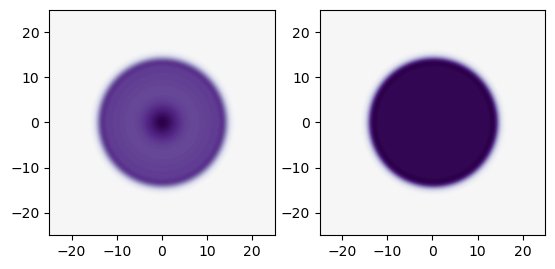

In [7]:
# get the energy needed for the phase shift φ
φ = 1*π
E = -φ * 2 * π * (1 + β) / α / λ_l^2 * Ee * sum(I) * Δimg^2

display(E)

lb = LaserBeam(I, λ_l, E, ximg, yimg)

ψ = smoothe([i^2 + j^2 < w^2 ? complex(1.) : complex(0.) for i in x, j in y], x, y, 1e-6)
extent_e = [x[1], x[end], y[1], y[end]].*1e6

eb = ElectronBeam(copy(ψ), U, x, y)
ebfree = ElectronBeam(copy(ψ), U, x, y)

phase_imprint = PhaseImprint(lb)
free = Free(eb, z)

setup1 = Setup(phase_imprint, free)
setup2 = Setup(free)

propagation!(eb, setup1)
propagation!(ebfree, setup2)

out_int = abs2.(eb.ψ)

pygui(false)
fig, (ax1, ax2) = subplots(1, 2)
ax1.imshow(out_int, cmap=violett, extent=extent_e)
ax2.imshow(abs2.(ebfree.ψ), cmap=violett, extent=extent_e)
;

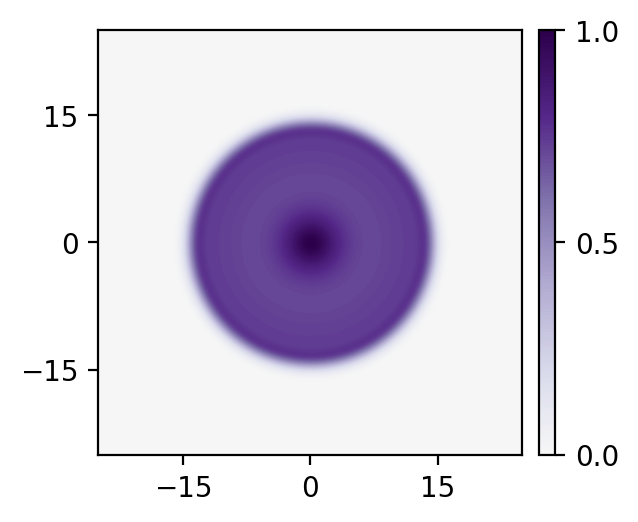

In [8]:
out = out_int ./ maximum(out_int)
out[1, 1] = 0

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)
plt = ax.imshow(out, cmap=violett, extent=extent_e)

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1 + 0.03, ax.get_position().y0,0.03, ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/pi_gauss/electron_intensity.svg", bbox_inches="tight", dpi=dpi)
;

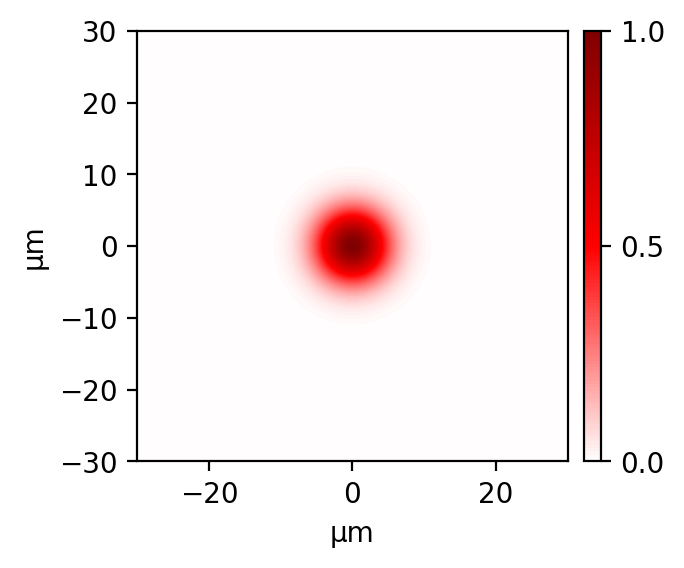

In [9]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

figsize = [7, 7] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
fig, ax = subplots(figsize = figsize, dpi=dpi)
plt = ax.imshow(I, cmap=red, extent=extent)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

cax = fig.add_axes([ax.get_position().x1 + 0.03, ax.get_position().y0,0.03, ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/pi_gauss/gaussian_intensity.svg", bbox_inches="tight", dpi=dpi)
;

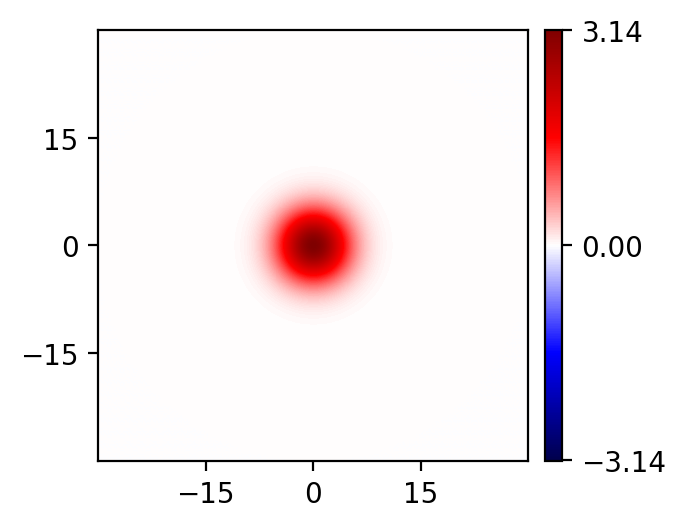

In [10]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

eb_plane = ElectronBeam(ones(ComplexF64, size(I)), U, ximg, yimg)
setup = Setup(PhaseImprint(lb))
propagation!(eb_plane, setup)

phase = angle.(eb_plane.ψ)

figsize = [7, 7] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
norm = PyPlot.matplotlib.colors.Normalize(vmin=-maximum(abs.(phase)), vmax=maximum(abs.(phase)))
fig, ax = subplots(figsize = figsize, dpi=dpi)
plt = ax.imshow(angle.(eb_plane.ψ), cmap="seismic", extent=extent, norm=norm)

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])


cax = fig.add_axes([ax.get_position().x1 + 0.03, ax.get_position().y0,0.03, ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[-3.14, 0, 3.14], cax=cax)

savefig("./images/pi_gauss/gaussian_phase.svg", bbox_inches="tight", dpi=dpi)
;

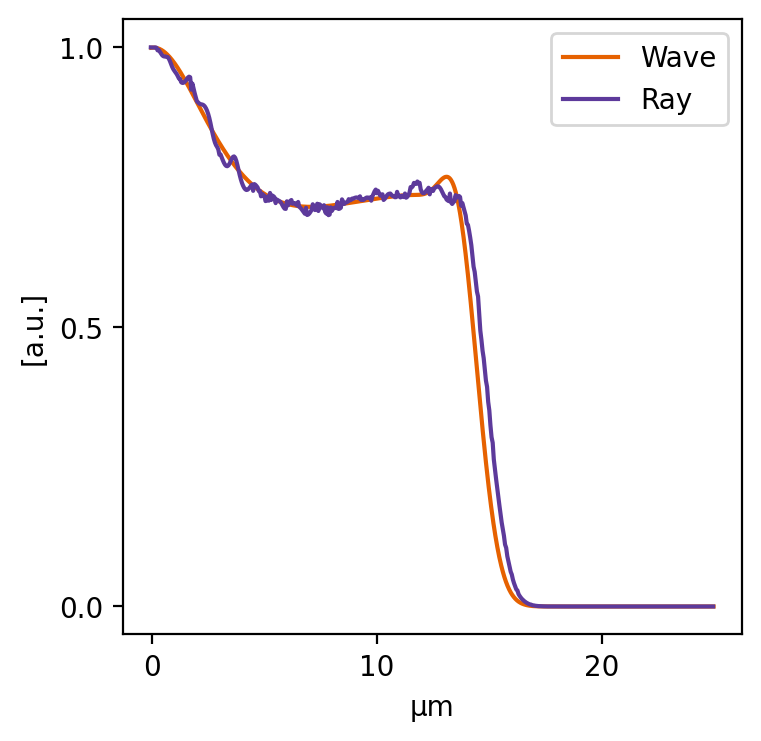

In [11]:
using Array2file

ray_radx = readfile("./data/radx.txt", Float64)
ray_xcross = readfile("./data/xcross.txt", Float64) .* 1e6

ray_radx ./= maximum(ray_radx)

cross = out[round(Int, size(out_int, 1)/2), round(Int, size(out_int, 2)/2):end]
xcross = x[round(Int, size(out_int, 2)/2):end] .* 1e6

figsize = [10, 10] ./ 2.504
fig, ax = subplots(figsize=figsize, dpi=dpi)

ax.plot(xcross, cross, label="Wave", color="#E66100")
ax.plot(ray_xcross, ray_radx, label="Ray", color="#5D3A9B")

ax.set_xticks([0, 10, 20])
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("µm")
ax.set_ylabel("[a.u.]")

ax.legend()

savefig("./images/pi_gauss/radial_comparison.svg", bbox_inches="tight", dpi=dpi)

;